# Tasks:
1. Comapre the pixel level changes between images aggregated to hexagon level (focusing on increase)
2. Main changes to identify: building, greenery, sidewalk, all kinds of furniture
3. Aggregate the changes to h3 level 6, 9, 12 and plot the variation in map
4. Segmentation summary using 04_seg_post-full.py !!! filter out images that are too small, likely to be underground
5. Count images per year per hexagon grid
6. visualize the sidewalk
7. visualize the captured motocycle, person,

In [1]:
import numpy as np
import os
import pandas as pd
import glob
import h3


ROOTFOLDER = "/lustre1/g/geog_pyloo/05_timemachine"
PANO_PATH = "{ROOTFOLDER}/GSV/gsv_rgb/{cityabbr}/gsvmeta/gsv_pano.csv"
CURATED_FOLDER = f"{ROOTFOLDER}/_curated"
META_PATH = "{ROOTFOLDER}/GSV/gsv_rgb/{cityabbr}/gsvmeta/{cityabbr}_meta.csv"

EXFOLDER = os.path.join(CURATED_FOLDER, "c_seg_crossectional_all")
if not os.path.exists(EXFOLDER):
    os.makedirs(EXFOLDER)
    
EXFOLDER_LONG = os.path.join(CURATED_FOLDER, "c_seg_longitudinal_all")
if not os.path.exists(EXFOLDER_LONG):
    os.makedirs(EXFOLDER_LONG)
    
TOTAL_PX = 160000
H3_RES = [8, 9, 12]

##################################################################
############### CLEAN UP SEG TYPE
##################################################################


def get_result(cityabbr, curated_folder, f_suffixes = "*panoptic.csv"):
    outfolder = f"{curated_folder}/{cityabbr}"
    seg_file = glob.glob(os.path.join(outfolder, f_suffixes))
    panoptic_df = []
    for p in seg_file:
        temp = pd.read_csv(p)
        panoptic_df.append(temp)
    panoptic_df = pd.concat(panoptic_df).reset_index(drop = True)
    return panoptic_df

def clean_seg(seg_df, pano_df):

    seg_df_summary = seg_df.groupby(["img", "labels"]).agg({'areas':'sum'}).reset_index()
    seg_df_summary['panoid'] = seg_df_summary['img'].apply(lambda x: x[:22])

    col_cols = ["labels"]
    index_cols = ["img", "year", "h3_8", "h3_9", "h3_12"]
    seg_df_summary_pano = seg_df_summary.merge(pano_df, on = ['panoid'])
    
    
    if seg_df_summary_pano.shape[0]<seg_df_summary.shape[0]:
        print("data missing after data join.")
        print("Before join: ", seg_df_summary.shape[0])
        print("After join: ",seg_df_summary_pano.shape[0])
    else:
        print("data consistent")
    
    seg_df_summary = seg_df_summary_pano.drop_duplicates(index_cols+col_cols)
    print("Segmentation shape: ", seg_df_summary.shape[0])
    seg_df_pivot = seg_df_summary.pivot(
        columns = col_cols,
        index = index_cols,
        values = "areas"
    ).reset_index().fillna(0)
    return seg_df_pivot

def get_opt(seg_df_pivot):
    all_labels = [x for x in seg_df_pivot.columns if str(x) in [str(s) for s in range(150)]]
    print("label length: ", len(all_labels))
    ops = {"img":"nunique"}
    for o in all_labels:
        ops[o] = "mean"
    return ops

def get_crossectional(seg_df_pivot):
    ops = get_opt(seg_df_pivot)
    
    h3_summary_no_year = []
    for res in H3_RES:
        # for each resolution of h3 id we get a average pixel of one category
        df_h3_summary = seg_df_pivot.groupby([f'h3_{res}']).agg(ops).reset_index()\
        .rename(columns = {f'h3_{res}':"hex_id", "img":"img_count"})
        df_h3_summary["res"] = res
        h3_summary_no_year.append(df_h3_summary)
        print("resolution: ", res)
    h3_summary_no_year = pd.concat(h3_summary_no_year).reset_index(drop = True)
    return h3_summary_no_year

# assume the data can be understand every year
def get_longitudinal(seg_df_pivot):
    ops = get_opt(seg_df_pivot)
    year_group1 = [2015,2016,2017,2018]
    year_group2 = [2020, 2021, 2022, 2023]
    null_group = [2019] # do not use this for now
    seg_df_summary_pano = seg_df_pivot[~seg_df_pivot["year"].isin(null_group)].reset_index(drop = True)
    seg_df_summary_pano['year_group'] = np.where(seg_df_summary_pano["year"]<=2018, '2015-2018', '2020-2023')
    
    h3_summary = []
    for res in H3_RES:
        # for each resolution of h3 id we get a average pixel of one category
        df_h3_summary = seg_df_summary_pano.groupby([f'h3_{res}','year_group']).agg(ops).reset_index()\
        .rename(columns = {f'h3_{res}':"hex_id", "img":"img_count"})
        df_h3_summary["res"] = res
        h3_summary.append(df_h3_summary)
    h3_summary = pd.concat(h3_summary).reset_index(drop = True)
    return h3_summary


def load_data(city):
    cityabbr = city.lower().replace(" ", "")
    seg_df = get_result(cityabbr, CURATED_FOLDER, f_suffixes = "*seg.csv")
    pano_df = pd.read_csv(PANO_PATH.format(
    ROOTFOLDER = ROOTFOLDER,
    cityabbr = cityabbr
    ))[['panoid', 'lat', 'lon', 'year', 'month']]

    for res in H3_RES:
        pano_df[f'h3_{res}'] = pano_df.apply(lambda x: h3.geo_to_h3(x.lat, x.lon, res), axis=1)
        
    meta_df = pd.read_csv(META_PATH.format(
        ROOTFOLDER = ROOTFOLDER,
        cityabbr = cityabbr
    ))
    # here make sure 
    
    seg_df_pivot = clean_seg(seg_df, pano_df)
    seg_crossectional = get_crossectional(seg_df_pivot)
    seg_longitudinal = get_longitudinal(seg_df_pivot)
    seg_crossectional.columns = [str(x) for x in seg_crossectional.columns]
    seg_longitudinal.columns = [str(x) for x in seg_longitudinal.columns]
    seg_crossectional.to_parquet(os.path.join(EXFOLDER, cityabbr+".parquet"), index = False)
    seg_longitudinal.to_parquet(os.path.join(EXFOLDER_LONG, cityabbr+".parquet"), index = False)
    print(f"city {cityabbr} saved")
    print("*"*50)
    
def check_finished():
    finished = [x.split(".")[0] for x in os.listdir(EXFOLDER)]
    return finished
    
def load_all():

    city_meta = pd.read_csv("../city_meta.csv")
    return city_meta
# step 1


city_meta = load_all()
# finished = check_finished()
allcity = city_meta["City"].values
# city_to_process = ["Chicago"]
# for city in city_to_process:
#     cityabbr = city.lower().replace(" ", "")

#     # try:
#     load_data(cityabbr)
        # except:
        #     print(f"check problem for this city {city}")



In [4]:
city_to_process = ['Bangkok']
city = city_to_process[0]
cityabbr = city.lower().replace(" ", "")
cityabbr = city.lower().replace(" ", "")
seg_df = get_result(cityabbr, CURATED_FOLDER, f_suffixes = "*seg.csv")
pano_df = pd.read_csv(PANO_PATH.format(
ROOTFOLDER = ROOTFOLDER,
cityabbr = cityabbr
))[['panoid', 'lat', 'lon', 'year', 'month']]

# for res in H3_RES:
#     pano_df[f'h3_{res}'] = pano_df.apply(lambda x: h3.geo_to_h3(x.lat, x.lon, res), axis=1)
    
meta_df = pd.read_csv(META_PATH.format(
    ROOTFOLDER = ROOTFOLDER,
    cityabbr = cityabbr
))

In [5]:
meta_df['img']= meta_df['path'].apply(lambda x: x.split("/")[-1].split(".")[0])
seg_df['panoid'] = seg_df['img'].apply(lambda x: x[:22])


## Visualize the walkable environment
1. find a image with sidewalk
2. find an image without sidewalk

In [60]:
sidewalk = 11
seg_sidewalk = seg_df[seg_df['labels']==sidewalk].reset_index(drop = True)
seg_with_road = seg_df[seg_df['labels'].isin([6])].reset_index(drop = True)
no_seg_sidewalk = seg_df[~seg_df['img'].isin(seg_sidewalk['img'].unique())].reset_index(drop = True)
no_seg_sidewalk_withroad = seg_df[seg_df['img'].isin(seg_with_road['img'].unique())].reset_index(drop = True)
seg_with_motorcyle = seg_df[seg_df['labels'].isin([116])].reset_index(drop = True)
seg_with_person = seg_df[seg_df['labels'].isin([12])].reset_index(drop = True)

seg_with_motorcyle.head()

,labels,areas,img,panoid
0,116,3271,fMuV2KAlBJErZSPXV-Kkfw_90,fMuV2KAlBJErZSPXV-Kkfw
1,116,171,ZJhYPpKK9ASNPgvQG8WoOA_0,ZJhYPpKK9ASNPgvQG8WoOA
2,116,1471,hF79-yYESHCL5V-uvUWpjA_180,hF79-yYESHCL5V-uvUWpjA
3,116,4286,1zRgdxhM-xiUgRtYWQ8LxQ_0,1zRgdxhM-xiUgRtYWQ8LxQ
4,116,139,GD9GMrBKbh1xy7MsR89z_Q_180,GD9GMrBKbh1xy7MsR89z_Q


In [94]:
image_with_sidewalk = 'PlJ7UwBg_FvwVr-WA51iXw_180'
# '5VjQ6EDEUsktNS7nk8LGRg_180'
# image_without_sidewalk = no_seg_sidewalk['img'].sample(1).values[0]
image_without_sidewalk = 'KxUw4oQFcKfW70gnY9IlSA_0'
image_without_sidewalk_withexposure = 'DhoUYFzhWoAF3tGXiHHbfA_0'
# image_with_motor ='f6doTP9Fzs7d83xVA8Ytug_90'
image_with_motor = 'XZbTPjobG_sDtOJEppJxjw_90'
# copy these images to the demo folder
demo_folder = "/lustre1/g/geog_pyloo/05_timemachine/_curated/semantic_inference"
for img in [image_with_sidewalk, image_without_sidewalk, image_without_sidewalk_withexposure, image_with_motor]:
    img_path = os.path.join(demo_folder, img+".jpg")
    print(img_path)
    print(meta_df[meta_df['img']==img]['path'].values[0])
    os.system(f"cp {meta_df[meta_df['img']==img]['path'].values[0]} {img_path}")
    print("*"*50)

/lustre1/g/geog_pyloo/05_timemachine/_curated/semantic_inference/PlJ7UwBg_FvwVr-WA51iXw_180.jpg
/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/bangkok/img_rgb/9_1/a/c/PlJ7UwBg_FvwVr-WA51iXw_180.jpg
**************************************************
/lustre1/g/geog_pyloo/05_timemachine/_curated/semantic_inference/KxUw4oQFcKfW70gnY9IlSA_0.jpg
/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/bangkok/img_rgb/1_1/0/4/KxUw4oQFcKfW70gnY9IlSA_0.jpg
**************************************************
/lustre1/g/geog_pyloo/05_timemachine/_curated/semantic_inference/DhoUYFzhWoAF3tGXiHHbfA_0.jpg
/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/bangkok/img_rgb/c_1/8/b/DhoUYFzhWoAF3tGXiHHbfA_0.jpg
**************************************************
/lustre1/g/geog_pyloo/05_timemachine/_curated/semantic_inference/XZbTPjobG_sDtOJEppJxjw_90.jpg
/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/bangkok/img_rgb/2_1/0/b/XZbTPjobG_sDtOJEppJxjw_90.jpg
**************************************************


Text(0.5, 1.0, 'Image without sidewalk')

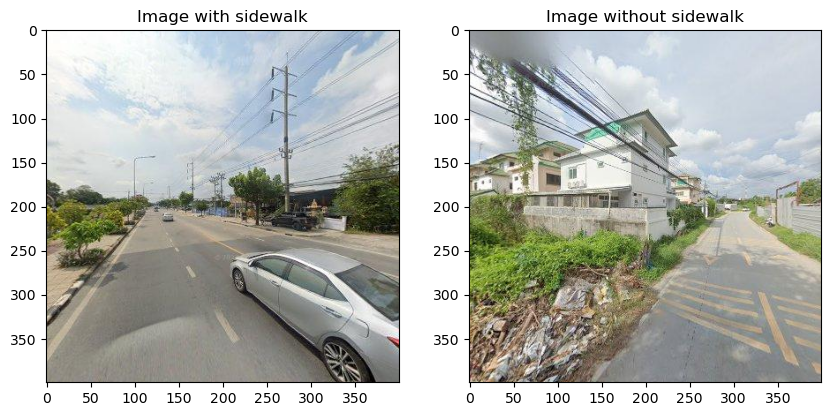

In [51]:
path_with_sidewalk = meta_df[meta_df['img']==image_with_sidewalk]['path'].values[0]
path_without_sidewalk = meta_df[meta_df['img']==image_without_sidewalk_withexposure]['path'].values[0]
# load image
import cv2
import matplotlib.pyplot as plt
img_with_sidewalk = cv2.imread(path_with_sidewalk)
img_without_sidewalk = cv2.imread(path_without_sidewalk)
# plot image side by side
fig, ax = plt.subplots(1,2, figsize = (10, 5))
ax[0].imshow(cv2.cvtColor(img_with_sidewalk, cv2.COLOR_BGR2RGB))
ax[0].set_title("Image with sidewalk")
ax[1].imshow(cv2.cvtColor(img_without_sidewalk, cv2.COLOR_BGR2RGB))
ax[1].set_title("Image without sidewalk")

2o0bOSg1h5kvSRBxwJC8Ug_90


Text(0.5, 1.0, 'Image with person')

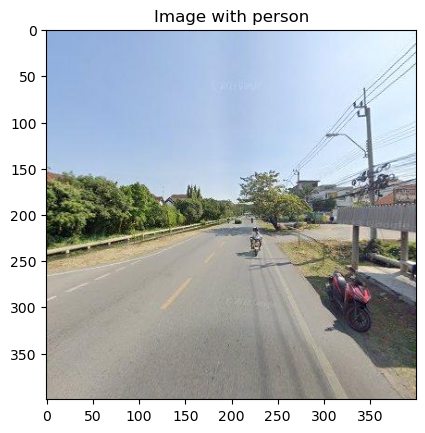

In [93]:
# plot image with motorcycle
image_with_motor = seg_with_person['img'].sample(1).values[0]
print(image_with_motor)
path_with_motor = meta_df[meta_df['img']==image_with_motor]['path'].values[0]
img_with_motor = cv2.imread(path_with_motor)
plt.imshow(cv2.cvtColor(img_with_motor, cv2.COLOR_BGR2RGB))
plt.title("Image with person")

In [65]:
print("unique number of panoid in the segmented result: ", seg_df['panoid'].nunique())

unique number of panoid in the segmented result:  204737


In [14]:
# check for panoid in seg_df, but not in meta_df
seg_pano = seg_df['panoid'].unique()
meta_df_pano = meta_df['panoid'].unique()
print("pano in seg but not in meta: ", len(set(seg_pano)-set(meta_df_pano)))


pano in seg but not in meta:  0


In [18]:
seg_pano_size = seg_df.merge(meta_df[['img', 'size']], on = ['img'])

In [21]:
seg_pano_size.drop_duplicates("img")['size'].describe()

count    478165.000000
mean      38957.913990
std        9704.264073
min        2207.000000
25%       31929.000000
50%       38094.000000
75%       45396.000000
max       72656.000000
Name: size, dtype: float64

In [23]:
pano_sample = '11vybLC_FTpvXOeKFxRbIQ'
seg_pano_size[seg_pano_size['panoid']==pano_sample]

,labels,areas,img,Unnamed: 0,panoid,size
125873,0,79271,11vybLC_FTpvXOeKFxRbIQ_0,7593.0,11vybLC_FTpvXOeKFxRbIQ,41084
125874,2,42059,11vybLC_FTpvXOeKFxRbIQ_0,7594.0,11vybLC_FTpvXOeKFxRbIQ,41084
125875,6,38670,11vybLC_FTpvXOeKFxRbIQ_0,7595.0,11vybLC_FTpvXOeKFxRbIQ,41084
125876,0,31910,11vybLC_FTpvXOeKFxRbIQ_90,7596.0,11vybLC_FTpvXOeKFxRbIQ,44684
125877,2,26,11vybLC_FTpvXOeKFxRbIQ_90,7597.0,11vybLC_FTpvXOeKFxRbIQ,44684
125878,5,65219,11vybLC_FTpvXOeKFxRbIQ_90,7598.0,11vybLC_FTpvXOeKFxRbIQ,44684
125879,6,55348,11vybLC_FTpvXOeKFxRbIQ_90,7599.0,11vybLC_FTpvXOeKFxRbIQ,44684
125880,20,5735,11vybLC_FTpvXOeKFxRbIQ_90,7600.0,11vybLC_FTpvXOeKFxRbIQ,44684
125881,82,1755,11vybLC_FTpvXOeKFxRbIQ_90,7601.0,11vybLC_FTpvXOeKFxRbIQ,44684
125882,102,7,11vybLC_FTpvXOeKFxRbIQ_90,7602.0,11vybLC_FTpvXOeKFxRbIQ,44684


In [27]:
# sample one city to conduct the test
cityabbr = "belohorizonte"
ROOTFOLDER = "/lustre1/g/geog_pyloo/05_timemachine"
PANO_PATH = "{ROOTFOLDER}/GSV/gsv_rgb/{cityabbr}/gsvmeta/gsv_pano.csv"
CURATED_FOLDER = f"{ROOTFOLDER}/_curated"
META_PATH = "{ROOTFOLDER}/GSV/gsv_rgb/{cityabbr}/gsvmeta/{cityabbr}_meta.csv"

EXFOLDER = os.path.join(CURATED_FOLDER, "c_seg_crossectional")
if not os.path.exists(EXFOLDER):
    os.makedirs(EXFOLDER)
    
EXFOLDER_LONG = os.path.join(CURATED_FOLDER, "c_seg_longitudinal")
if not os.path.exists(EXFOLDER_LONG):
    os.makedirs(EXFOLDER_LONG)

panoptic_df = get_result(cityabbr,CURATED_FOLDER, f_suffixes = "*panoptic.csv")
seg_df = get_result(cityabbr, CURATED_FOLDER, f_suffixes = "*seg.csv")
# meta_df = pd.read_csv(META_PATH.format(
#     ROOTFOLDER = ROOTFOLDER,
#     cityabbr = cityabbr
# ))
# pano_df = pd.read_csv(PANO_PATH.format(
#     ROOTFOLDER = ROOTFOLDER,
#     cityabbr = cityabbr
# ))[['panoid', 'lat', 'lon', 'year', 'month']]

# for res in [6,9,12]:
#     pano_df[f'h3_{res}'] = pano_df.apply(lambda x: h3.geo_to_h3(x.lat, x.lon, res), axis=1)

In [30]:
path_df = pd.read_csv(f"/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/{cityabbr}/gsvmeta/{cityabbr}_meta.csv")
path_df.head()

,path,panoid,size,lat,lon,year,month,id,h3_res8,h3_res9,dist_hav,data_group,ring
0,/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_r...,f2ZLXxjkm2jSYYg0aN5MFw,41946,-19.788920,-43.950674,2019.0,5.0,134109.0,88a88ccb55fffff,89a88ccb557ffff,14524.415331,train,NaN
1,/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_r...,f2ZLXxjkm2jSYYg0aN5MFw,29130,-19.788920,-43.950674,2019.0,5.0,134109.0,88a88ccb55fffff,89a88ccb557ffff,14524.415331,train,NaN
2,/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_r...,f2ZLXxjkm2jSYYg0aN5MFw,34900,-19.788920,-43.950674,2019.0,5.0,134109.0,88a88ccb55fffff,89a88ccb557ffff,14524.415331,train,NaN
3,/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_r...,f2ZLXxjkm2jSYYg0aN5MFw,49808,-19.788920,-43.950674,2019.0,5.0,134109.0,88a88ccb55fffff,89a88ccb557ffff,14524.415331,train,NaN
4,/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_r...,v69kKVvCgGBstJi24fZ4OQ,28326,-19.801781,-43.961636,2015.0,11.0,70899.0,88a88ccb59fffff,89a88ccb593ffff,13259.382046,train,NaN


In [34]:
seg_df[seg_df['img']=='v69kKVvCgGBstJi24fZ4OQ_270']

,labels,areas,img
1605835,0,730,v69kKVvCgGBstJi24fZ4OQ_270
1605836,1,16617,v69kKVvCgGBstJi24fZ4OQ_270
1605837,2,64545,v69kKVvCgGBstJi24fZ4OQ_270
1605838,4,11813,v69kKVvCgGBstJi24fZ4OQ_270
1605839,6,54956,v69kKVvCgGBstJi24fZ4OQ_270
1605840,9,702,v69kKVvCgGBstJi24fZ4OQ_270
1605841,11,8536,v69kKVvCgGBstJi24fZ4OQ_270
1605842,13,1,v69kKVvCgGBstJi24fZ4OQ_270
1605843,17,22,v69kKVvCgGBstJi24fZ4OQ_270
1605844,20,1473,v69kKVvCgGBstJi24fZ4OQ_270


In [18]:
path_df[path_df['panoid']=='v69kKVvCgGBstJi24fZ4OQ'].to_csv("/lustre1/g/geog_pyloo/05_timemachine/GSV/singapore_test.csv", index = False)

In [26]:
results = pd.read_csv("/lustre1/g/geog_pyloo/05_timemachine/_curated/c_segment_test.csv/singapore_test_4_seg.csv")
results

,labels,areas,img
0,1,8788,hdu1wXoeCoaDIT7Q7TM_Lw_180
1,2,8535,hdu1wXoeCoaDIT7Q7TM_Lw_180
2,4,55454,hdu1wXoeCoaDIT7Q7TM_Lw_180
3,6,23589,hdu1wXoeCoaDIT7Q7TM_Lw_180
4,9,53376,hdu1wXoeCoaDIT7Q7TM_Lw_180
5,13,5795,hdu1wXoeCoaDIT7Q7TM_Lw_180
6,43,666,hdu1wXoeCoaDIT7Q7TM_Lw_180
7,52,3627,hdu1wXoeCoaDIT7Q7TM_Lw_180
8,87,52,hdu1wXoeCoaDIT7Q7TM_Lw_180
9,116,118,hdu1wXoeCoaDIT7Q7TM_Lw_180


In [20]:
# only infer these
line = """
python inference.py --config-file ../configs/ade20k/swin/oneformer_swin_large_bs16_160k_1280x1280.yaml \
--input /lustre1/g/geog_pyloo/05_timemachine/GSV/singapore_test.csv \
--outfolder /lustre1/g/geog_pyloo/05_timemachine/_curated/c_segment_test.csv \
--task semantic \
--opts MODEL.IS_TRAIN False MODEL.IS_DEMO True MODEL.WEIGHTS ../ckpt/1280x1280_250_16_swin_l_oneformer_ade20k_160k.pth
"""
print(line)


python inference.py --config-file ../configs/ade20k/swin/oneformer_swin_large_bs16_160k_1280x1280.yaml --input /lustre1/g/geog_pyloo/05_timemachine/GSV/singapore_test.csv --outfolder /lustre1/g/geog_pyloo/05_timemachine/_curated/c_segment_test.csv --task semantic --opts MODEL.IS_TRAIN False MODEL.IS_DEMO True MODEL.WEIGHTS ../ckpt/1280x1280_250_16_swin_l_oneformer_ade20k_160k.pth



In [ ]:
def get_seg_types():
    building = [0, 1, 25, 48]
    greenery = [4, 9, 17, 66, 72]
    street_furniture = [19, 15, 31, 69, 82, 136, 138]
    sidewalk = [11]
    car = [20, 80, 83, 102]
    person = [12]
    bike = [127, 116]
    sky = [2]
    sel = building + greenery + street_furniture + sidewalk + car + person + bike +sky
    other = [x for x in range(150) if not x in sel]

    obj_dicts = {
        # "building":building,
        # "greenery":greenery,
        "street_furniture":street_furniture,
        # "sidewalk": sidewalk,
        "car":car,
        "person":person,
        "bike":bike,
        # "sky":sky,
        "other":other,
    }
    def get_cat(label):
        for obj, v in obj_dicts.items():
            if label in v:
                return obj
    obj_dict_rev = {}
    for x in range(150):
        obj_dict_rev[x] = get_cat(x)
    ops = {}
    for label in list(obj_dicts.keys())[:-1]:
        ops[label] = "mean"
    return ops, obj_dict_rev

def get_result(cityabbr, curated_folder, f_suffixes = "*panoptic.csv"):
    outfolder = f"{curated_folder}/{cityabbr}"
    seg_file = glob.glob(os.path.join(outfolder, f_suffixes))
    panoptic_df = []
    for p in seg_file:
        temp = pd.read_csv(p)
        panoptic_df.append(temp)
    panoptic_df = pd.concat(panoptic_df).reset_index(drop = True)
    return panoptic_df

def clean_pano(panoptic_df, ring):
    _, obj_dict_rev = get_seg_types()
    panoptic_df['cat'] = panoptic_df["category_id"].apply(lambda x: obj_dict_rev[x])
    
    panoptic_df = panoptic_df[~panoptic_df['cat'].isin(['other', 'greenery'])].reset_index(drop = True)
    panoptic_df_summary = panoptic_df[panoptic_df['isthing']==True].groupby(["img","cat"])['id'].nunique().reset_index()
    panoptic_df_summary = panoptic_df_summary[panoptic_df_summary["cat"]!="other"].reset_index(drop = True)
    panoptic_df_summary['panoid'] = panoptic_df_summary['img'].apply(lambda x: x[:22])
    panoptic_df_summary_pano = panoptic_df_summary.merge(ring, on = ['panoid'])
    if panoptic_df_summary_pano.shape[0]<panoptic_df_summary.shape[0]:
        print("data missing after data join.")
    else:
        print("data consistent")
    col_cols = ["cat"]
    index_cols = ["img", "year", "h3_6", "h3_9", "h3_12", "ring"]
    panoptic_df_summary_pano = panoptic_df_summary_pano.drop_duplicates(index_cols+col_cols)
    print("Segmentation shape: ", panoptic_df_summary_pano.shape[0])
    panoptic_df_pivot = panoptic_df_summary_pano.pivot(
        columns = ["cat"],
        index = ["img", "year", "h3_6", "h3_9", "h3_12", "ring"],
        values = "id"
    ).reset_index().fillna(0)
    return panoptic_df_pivot

def get_crossectional(panoptic_df_pivot, ops):
    
    h3_summary_no_year = []
    for res in [6, 9, 12]:
        # for each resolution of h3 id we get a average pixel of one category
        df_h3_summary = panoptic_df_pivot.groupby([f'h3_{res}', 'ring']).agg(ops).reset_index()\
        .rename(columns = {f'h3_{res}':"hex_id"})
        df_h3_summary["res"] = res
        h3_summary_no_year.append(df_h3_summary)
        print("resolution: ", res)
    h3_summary_no_year = pd.concat(h3_summary_no_year).reset_index(drop = True)
    return h3_summary_no_year

# assume the data can be understand every year
def get_longitudinal(panoptic_df_pivot, ops):
    year_group1 = [2015,2016,2017,2018]
    year_group2 = [2020, 2021, 2022, 2023]
    null_group = [2019] # do not use this for now
    panoptic_df_summary_pano = panoptic_df_pivot[~panoptic_df_pivot["year"].isin(null_group)].reset_index(drop = True)
    panoptic_df_summary_pano['year_group'] = np.where(panoptic_df_summary_pano["year"]<=2018, '2015-2018', '2020-2023')
    h3_summary = []
    for res in [6, 9, 12]:
        # for each resolution of h3 id we get a average pixel of one category
        df_h3_summary = panoptic_df_summary_pano.groupby([f'h3_{res}','ring','year_group']).agg(ops).reset_index()\
        .rename(columns = {f'h3_{res}':"hex_id"})
        df_h3_summary["res"] = res
        h3_summary.append(df_h3_summary)
    h3_summary = pd.concat(h3_summary).reset_index(drop = True)
    return h3_summary


def load_data_panotic(city, ops):
    cityabbr = city.lower().replace(" ", "")
    panoptic_df = get_result(cityabbr, CURATED_FOLDER)
    pano_df = pd.read_csv(PANO_PATH.format(
    ROOTFOLDER = ROOTFOLDER,
    cityabbr = cityabbr
    ))[['panoid', 'lat', 'lon', 'year', 'month']]

    for res in [6,9,12]:
        pano_df[f'h3_{res}'] = pano_df.apply(lambda x: h3.geo_to_h3(x.lat, x.lon, res), axis=1)
        
    meta_df = pd.read_csv(META_PATH.format(
        ROOTFOLDER = ROOTFOLDER,
        cityabbr = cityabbr
    ))

    ring = meta_df[['panoid', 'ring']].drop_duplicates().dropna().merge(pano_df, on = "panoid", how = "right")
    ring["ring"] = ring["ring"].fillna(-1)
    # here make sure 
    
    panoptic_df_pivot = clean_pano(panoptic_df, ring)
    panoptic_crossectional = get_crossectional(panoptic_df_pivot, ops)
    panoptic_longitudinal = get_longitudinal(panoptic_df_pivot, ops)

    panoptic_crossectional.to_parquet(os.path.join(EXFOLDER, cityabbr+".parquet"), index = False)
    panoptic_longitudinal.to_parquet(os.path.join(EXFOLDER_LONG, cityabbr+".parquet"), index = False)
    print(f"city {cityabbr} saved")
    print("*"*50)
    
    
def load_all():
    serviceaccount = "../../google_drive_personal.json"
    import gspread

    # from oauth2client.service_account import ServiceAccountCredentials
    gc = gspread.service_account(filename=serviceaccount)


    def read_url(url, SHEET_NAME):
        SHEET_ID = url.split("/")[5]
        spreadsheet = gc.open_by_key(SHEET_ID)
        worksheet = spreadsheet.worksheet(SHEET_NAME)
        rows = worksheet.get_all_records()
        df_spread = pd.DataFrame(rows)
        return df_spread, worksheet


    url = "https://docs.google.com/spreadsheets/d/1o5gFmZPUoDwrrbfE6M26uJF3HnEZll02ivnOxP6K6Xw/edit?usp=sharing"
    SHEETNAME = "select_city_classifier"
    city_meta, other_worksheet = read_url(url, SHEETNAME)
    city_meta = city_meta[city_meta['City']!=''].reset_index(drop = True)
    return city_meta

In [88]:
city_meta = load_all()
ops, obj_dict_rev = get_seg_types(op="mean")


In [303]:
seg_problem_city = ["Nagoya", "Lima", "Rio de Janeiro","Dhaka"] # seg problems
pano_problem_city = ["Rome", "Dehli"]+seg_problem_city
# remove these cities with problem. Milan still is a bit skeptical, need to check later.
FOLDERS_EXPORT = glob.glob(CURATED_FOLDER+"/c_*")[1:]
for f in FOLDERS_EXPORT:
    for city in pano_problem_city:
        city_abbr = city.lower().replace(" ", "")
        file = os.path.join(f, city_abbr + ".parquet")
        print(file)
        try:
            os.remove(file)
            print("file removed")
        except:
            print("file does not exists")

/lustre1/g/geog_pyloo/05_timemachine/_curated/c_seg_crossectional/rome.parquet
file removed
/lustre1/g/geog_pyloo/05_timemachine/_curated/c_seg_crossectional/dehli.parquet
file does not exists
/lustre1/g/geog_pyloo/05_timemachine/_curated/c_seg_crossectional/nagoya.parquet
file does not exists
/lustre1/g/geog_pyloo/05_timemachine/_curated/c_seg_crossectional/lima.parquet
file does not exists
/lustre1/g/geog_pyloo/05_timemachine/_curated/c_seg_crossectional/riodejaneiro.parquet
file does not exists
/lustre1/g/geog_pyloo/05_timemachine/_curated/c_seg_crossectional/dhaka.parquet
file does not exists
/lustre1/g/geog_pyloo/05_timemachine/_curated/c_pano_longitudinal/rome.parquet
file removed
/lustre1/g/geog_pyloo/05_timemachine/_curated/c_pano_longitudinal/dehli.parquet
file does not exists
/lustre1/g/geog_pyloo/05_timemachine/_curated/c_pano_longitudinal/nagoya.parquet
file removed
/lustre1/g/geog_pyloo/05_timemachine/_curated/c_pano_longitudinal/lima.parquet
file removed
/lustre1/g/geog_p

### DEBUGGING problematic cities

In [304]:
city = "Rome"
cityabbr = city.lower().replace(" ", "")
seg_df = get_result(cityabbr, CURATED_FOLDER, f_suffixes = "*seg.csv")
pano_df = pd.read_csv(PANO_PATH.format(
    ROOTFOLDER = ROOTFOLDER,
    cityabbr = cityabbr
    ))[['panoid', 'lat', 'lon', 'year', 'month']]

for res in [6,9,12]:
    pano_df[f'h3_{res}'] = pano_df.apply(lambda x: h3.geo_to_h3(x.lat, x.lon, res), axis=1)

meta_df = pd.read_csv(META_PATH.format(
    ROOTFOLDER = ROOTFOLDER,
    cityabbr = cityabbr
))

ring = meta_df[['panoid', 'ring']].drop_duplicates().dropna().merge(pano_df, on = "panoid", how = "right")
ring["ring"] = ring["ring"].fillna(-1)
# here make sure 

# seg_df_pivot = clean_seg(seg_df, ring)

In [305]:
panoptic_df = get_result(cityabbr,CURATED_FOLDER, f_suffixes = "*panoptic.csv")
panoptic_df = panoptic_df[~panoptic_df["img"].isna()]
panoptic_df["panoid"] = panoptic_df["img"].apply(lambda x: x[:22])
# panoptic_df[panoptic_df["panoid"].isin(validpano)]

In [306]:
panoptic_df = panoptic_df[~panoptic_df["img"].isna()].reset_index(drop = True)
panoptic_df["panoid"] = panoptic_df["img"].apply(lambda x: x[:22])

In [307]:
seg_df['cat'] = seg_df['labels'].apply(lambda x: obj_dict_rev[x])
seg_df_summary = seg_df.groupby(["img", "cat"]).agg({'areas':'sum'}).reset_index()
seg_df_summary = seg_df_summary[seg_df_summary["cat"]!="other"].reset_index(drop = True)
seg_df_summary['panoid'] = seg_df_summary['img'].apply(lambda x: x[:22])
seg_df_summary_pano = seg_df_summary.merge(ring, on = ['panoid'])

In [308]:
#############################################################
# process object counting later
panoptic_df["cat"] = panoptic_df["category_id"].apply(lambda x: obj_dict_rev[x])
# panoptic_df = panoptic_df[~panoptic_df['cat'].isin(['other', 'greenery'])].reset_index(drop = True)
p_summary = panoptic_df[panoptic_df['isthing']==True].groupby(["img","cat"])['id'].nunique().reset_index()
p_summary["panoid"] = p_summary["img"].apply(lambda x: x[:22])
p_summary.shape

(5693, 4)

In [324]:
validpano = meta_df["panoid"].unique()
meta_df["img"] = meta_df["path"].apply(lambda x: x.split("/")[-1].split(".")[0])
validpath = meta_df[meta_df["img"].isin(panoptic_df["img"].values)]["path"].unique()

/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/rome/img_rgb/5_1/1/1/nW74HJ9ki51vOQ0X1BGJcg_90.jpg


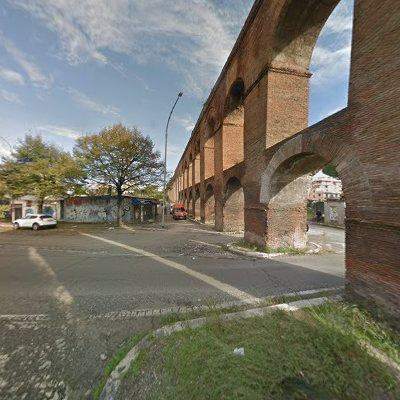

In [338]:
# debugging

test = validpath[1600]

from PIL import Image
print(test)
Image.open(test)


In [339]:
img_name = test.split("/")[-1].split(".")[0]
seg_df[seg_df["img"].isin([img_name])]

,labels,areas,img,cat
30084,1,30611,nW74HJ9ki51vOQ0X1BGJcg_90,building
30085,2,35776,nW74HJ9ki51vOQ0X1BGJcg_90,sky
30086,4,8659,nW74HJ9ki51vOQ0X1BGJcg_90,greenery
30087,6,40807,nW74HJ9ki51vOQ0X1BGJcg_90,other
30088,9,22880,nW74HJ9ki51vOQ0X1BGJcg_90,greenery
30089,20,678,nW74HJ9ki51vOQ0X1BGJcg_90,car
30090,61,20432,nW74HJ9ki51vOQ0X1BGJcg_90,other
30091,87,157,nW74HJ9ki51vOQ0X1BGJcg_90,other


In [340]:
panoptic_df[panoptic_df["img"]==img_name]

,id,isthing,category_id,area,img,panoid,cat
22278,1,False,6,38927,nW74HJ9ki51vOQ0X1BGJcg_90,nW74HJ9ki51vOQ0X1BGJcg,other
22279,2,False,9,22756,nW74HJ9ki51vOQ0X1BGJcg_90,nW74HJ9ki51vOQ0X1BGJcg,greenery
22280,3,False,4,8683,nW74HJ9ki51vOQ0X1BGJcg_90,nW74HJ9ki51vOQ0X1BGJcg,greenery
22281,4,False,1,46370,nW74HJ9ki51vOQ0X1BGJcg_90,nW74HJ9ki51vOQ0X1BGJcg,building
22282,5,True,20,687,nW74HJ9ki51vOQ0X1BGJcg_90,nW74HJ9ki51vOQ0X1BGJcg,car
22283,6,False,2,35762,nW74HJ9ki51vOQ0X1BGJcg_90,nW74HJ9ki51vOQ0X1BGJcg,sky


In [313]:
demo_folder = "/lustre1/g/geog_pyloo/05_timemachine/_demo"
if not os.path.exists(demo_folder):
    os.makedirs(demo_folder)

In [314]:
# reinference and check result on image
path_to_checkpoint  = "../ckpt/250_16_swin_l_oneformer_ade20k_160k.pth"
bash_c = f"""
cd /home/yuanzf/_playground/OneFormer/demo

python demo.py --config-file ../configs/ade20k/swin/oneformer_swin_large_bs16_160k.yaml \
--input {test} \
--output {demo_folder}_milan \
--task panoptic \
--opts MODEL.IS_TRAIN False MODEL.IS_DEMO True MODEL.WEIGHTS {path_to_checkpoint}

python demo.py --config-file ../configs/ade20k/swin/oneformer_swin_large_bs16_160k.yaml \
--input {test} \
--output {demo_folder}_{cityabbr} \
--task semantic \
--opts MODEL.IS_TRAIN False MODEL.IS_DEMO True MODEL.WEIGHTS {path_to_checkpoint}
"""
print(bash_c)


cd /home/yuanzf/_playground/OneFormer/demo

python demo.py --config-file ../configs/ade20k/swin/oneformer_swin_large_bs16_160k.yaml --input /lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/rome/img_rgb/c_1/3/1/9CZRl276eI6jy0SKJ2htxA_0.jpg --output /lustre1/g/geog_pyloo/05_timemachine/_demo_milan --task panoptic --opts MODEL.IS_TRAIN False MODEL.IS_DEMO True MODEL.WEIGHTS ../ckpt/250_16_swin_l_oneformer_ade20k_160k.pth

python demo.py --config-file ../configs/ade20k/swin/oneformer_swin_large_bs16_160k.yaml --input /lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/rome/img_rgb/c_1/3/1/9CZRl276eI6jy0SKJ2htxA_0.jpg --output /lustre1/g/geog_pyloo/05_timemachine/_demo_rome --task semantic --opts MODEL.IS_TRAIN False MODEL.IS_DEMO True MODEL.WEIGHTS ../ckpt/250_16_swin_l_oneformer_ade20k_160k.pth



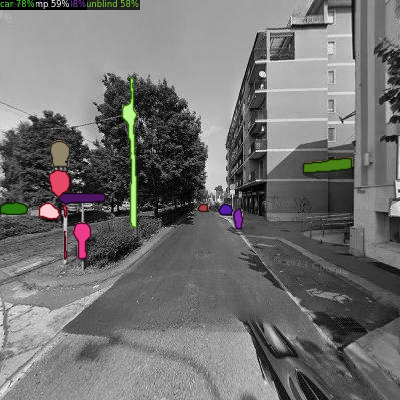

In [255]:
demo_result = "/lustre1/g/geog_pyloo/05_timemachine/_demo_milan.png"
Image.open(demo_result)

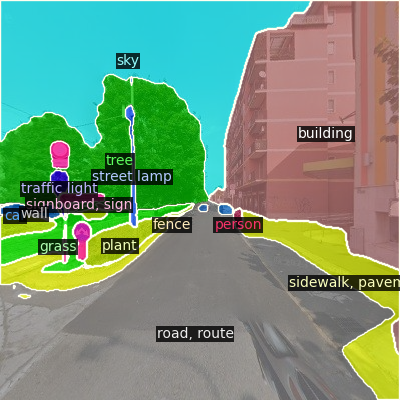

In [257]:
demo_result = "/lustre1/g/geog_pyloo/05_timemachine/_demo_milan_seg.png"
Image.open(demo_result)

In [258]:
[{'id': 1, 'isthing': False, 'category_id': 1}, {'id': 2, 'isthing': False, 'category_id': 4}, {'id': 3, 'isthing': False, 'category_id': 17}, {'id': 4, 'isthing': False, 'category_id': 6}, {'id': 5, 'isthing': True, 'category_id': 20}, {'id': 6, 'isthing': True, 'category_id': 43}, {'id': 7, 'isthing': True, 'category_id': 20}, {'id': 8, 'isthing': False, 'category_id': 11}, {'id': 9, 'isthing': True, 'category_id': 136}, {'id': 10, 'isthing': True, 'category_id': 12}, {'id': 11, 'isthing': False, 'category_id': 9}, {'id': 12, 'isthing': False, 'category_id': 2}]

[{'id': 1, 'isthing': False, 'category_id': 1},
 {'id': 2, 'isthing': False, 'category_id': 4},
 {'id': 3, 'isthing': False, 'category_id': 17},
 {'id': 4, 'isthing': False, 'category_id': 6},
 {'id': 5, 'isthing': True, 'category_id': 20},
 {'id': 6, 'isthing': True, 'category_id': 43},
 {'id': 7, 'isthing': True, 'category_id': 20},
 {'id': 8, 'isthing': False, 'category_id': 11},
 {'id': 9, 'isthing': True, 'category_id': 136},
 {'id': 10, 'isthing': True, 'category_id': 12},
 {'id': 11, 'isthing': False, 'category_id': 9},
 {'id': 12, 'isthing': False, 'category_id': 2}]